In [1]:
import numpy as np
import PWBeamformer as pwb
import scipy.signal as sig
import pyus.data.io as dio
import matplotlib.pyplot as plt

# Load file
print("Reading file")
filedir = "/home/wren/Documents/phdprojects/data/20230208_developmentrf/acq_wire/"
filename = "20230208_153318694"

params = dio.loadmat(filename=filename+"_RF", filedir=filedir)
nsamp = 2*4*(params['track_params']['rx']['endDepth'] - params['track_params']['startDepth'])
nsamp = int(np.ceil(nsamp/128) * 128)
rf_raw = np.fromfile(filedir+filename+"_RF.bin", dtype=np.int16)
rf_raw = rf_raw.reshape((-1,params['trans']['nele']), order='f')

na = params['track_params']['rf']['na']
numrot = params['track_params']['numrot']

print("Reshaping")
rf = []
for rot in range(numrot):
    rotdata = []
    for ang in range(na):
        indmin = (rot*na + ang)*nsamp
        indmax = indmin + nsamp
        rotdata.append(rf_raw[indmin:indmax,:])
    rf.append(rotdata)
rf = np.array(rf).transpose(2, 3, 1, 0).astype(float)
fs = 20.833E6

print("UPsamplng")
usf_ax = int(8)
t = params['track_params']['startDepth']/params['f'] + np.arange(nsamp)/fs
tstart = params['track_params']['startDepth']/params['f']
rf, t = sig.resample(rf, rf.shape[0]*usf_ax, t, axis=0)
Ts = np.mean(np.diff(t))
Nt = len(t)

print("  ", rf.shape)

print("image parameters")
# IMaging parameters
c = 1540        # speed of sound in medium [m/s - coldish water]
fs = 20.833E6   # sampling frequency [Hz]
ddeg = params['track_params']['rf']['ddeg']
dtheta = ddeg * np.pi/180
na = params['track_params']['rf']['na']
thetas = dtheta*(np.arange(na)-(na-1)/2)

# Transducer parameters
dele = 0.298E-3 # element spacing [meters]
nele = 128      # number of elements

# Recon parameters
dz = c/(4*fs)
zmin = 1.5E-3
zmax = 40E-3
dx = 0.2E-3
xmin = -dele * (nele-1)/2
xmax = dele * (nele-1)/2
dy = 0.2E-3
ymin = 0E-3
ymax = 0E-3

# Generate element grid
xele = dele*(np.arange(nele) - (nele-1)/2)
yele = 0
zele = 0
Xele, Yele, Zele = np.meshgrid(xele, yele, zele)
eles = np.array([Xele.flatten(), Yele.flatten(), Zele.flatten()]).T

# Generate recon grid
xgrid = np.arange(xmin, xmax, dx)
ygrid = 0 #np.arange(ymin, ymax, dy)
zgrid = np.arange(zmin, zmax, dz)
Xgrid, Ygrid, Zgrid = np.meshgrid(xgrid, ygrid, zgrid)
field = np.array([Xgrid.flatten(), Ygrid.flatten(), Zgrid.flatten()]).T

thetas = dtheta*(np.arange(na)-(na-1)/2)

trefs = []
for inda in range(na):
    tref = np.sin(thetas[inda])*xele/c
    tref = tref - np.min(tref)
    trefs.append(tref)
trefs = np.array(trefs).flatten()

print(trefs.shape)

# initialize beamformer
params = {}
params['c'] = c
params['fnum'] = 2
params['points'] = field
params['trefs'] = trefs
print(eles.shape)
params['refs'] = np.tile(eles, (na,1))
params['alphas'] = np.repeat(thetas, nele)
params['nsamp'] = rf.shape[0]
params['ts'] = Ts
params['tstart'] = 0

for (k, v) in params.items():
    try:
        print(k, v.shape)
    except Exception as e:
        print(k, "welp...")

Reading file
Reshaping
UPsamplng
   (12288, 128, 11, 36)
image parameters
(1408,)
(128, 3)
c welp...
fnum welp...
points (395960, 3)
trefs (1408,)
refs (1408, 3)
alphas (1408,)
nsamp welp...
ts ()
tstart welp...


In [2]:
print("Preparing Beamfomrer...")

bruh = pwb.PWBeamformer(**params)

print("Slicing data")
rfslice = rf[:,:,0,0]
for ind in range(rf.shape[2]-1):
    rfslice = np.concatenate((rfslice, rf[:,:,ind+1,0]), axis = 1)

print("Breamforming")

Preparing Beamfomrer...
Initializing tabs
Initializing Masks
Slicing data
Breamforming
Shape: (12288, 1408)
Tinds shape 1408 (395960,)
1408 (395960,)
[ 712.3680603   427.3916333    16.77725503 ...   20.19558909  -68.
 -104.78102288]
[ 1033  1037  1041 ... 10212 10216 10219]
Finished with it


In [12]:
summed = bruh(rfslice)
print("Finished with it")

Shape: (12288, 1408)
Tinds shape 1408 (395960,)
1408 (395960,)
[ 712.3680603   427.3916333    16.77725503 ...   20.19558909  -68.
 -104.78102288]
[ 1033  1037  1041 ... 10212 10216 10219]
Finished with it


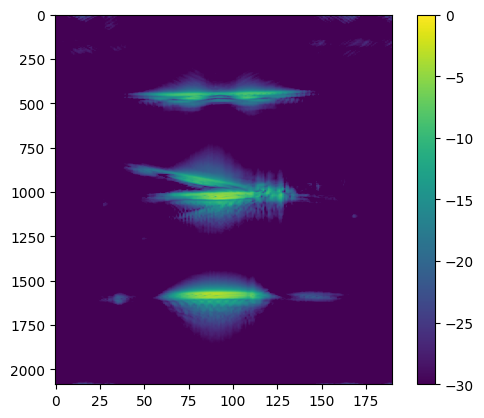

In [11]:
summed = np.abs(summed.reshape((len(zgrid), len(xgrid)), order='f'))
env = np.abs(sig.hilbert(summed, axis=0))
logged = 20*np.log10(env/np.max(env))
plt.figure()
plt.imshow(logged, aspect = 0.1, vmin=-30, vmax=0)
plt.colorbar()
plt.show()

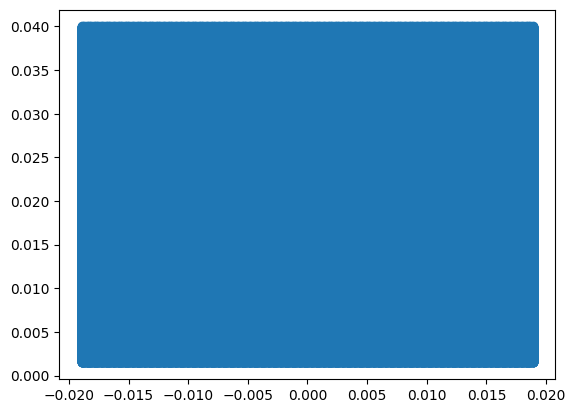

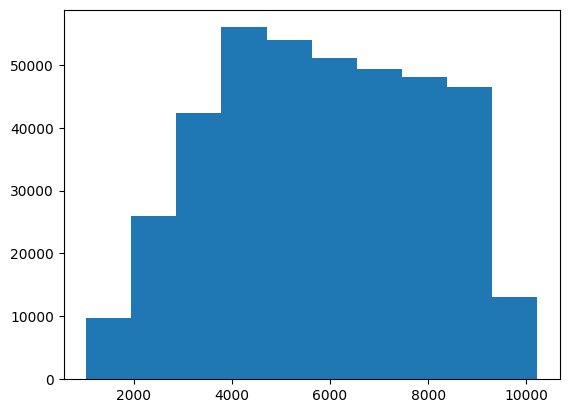

In [4]:
pwb.POINTS
plt.figure()
plt.scatter(pwb.POINTS[:,0], pwb.POINTS[:,2])
plt.show()

plt.figure()
plt.hist(pwb.TINDS[0])
plt.show()

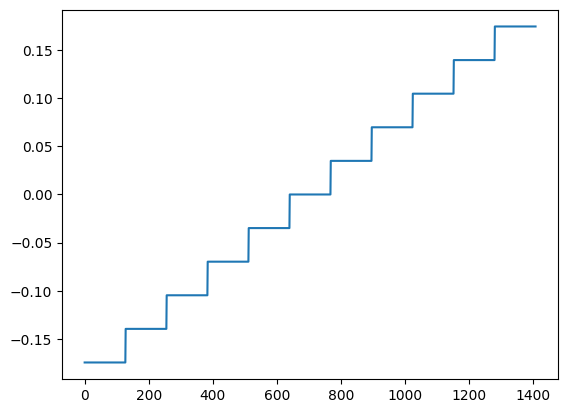

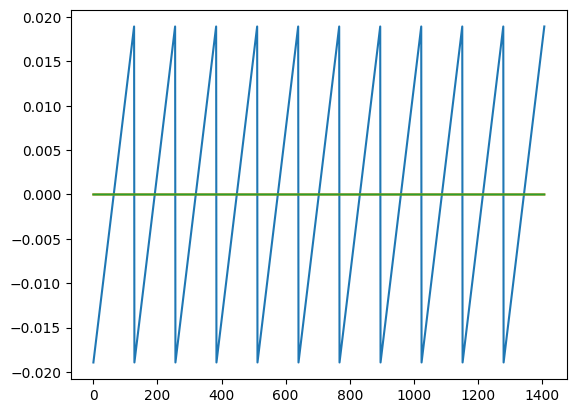

In [5]:
plt.figure()
plt.plot(params['alphas'][:1408])
plt.show()

plt.figure()
plt.plot(params['refs'][:,0])
plt.plot(params['refs'][:,1])
plt.plot(params['refs'][:,2])
plt.show()